In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install Libraries

In [ ]:
!pip install catboost

In [ ]:
!pip install xgboost

In [ ]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


### Load Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostClassifier, Pool
import xgboost as xgb

#F1-Score Expectation Maximization in O(n^2)
#https://www.kaggle.com/mmueller/f1-score-expectation-maximization-in-o-n
#https://github.com/KazukiOnodera/Instacart/blob/master/py_model/opt_fscore.py

from f1optimization_faron import get_best_prediction

from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score , log_loss

from datetime import datetime
from tqdm import tqdm
import pickle


### Load Data

In [ ]:
#HDF5 format preserves data type after changing them
data = pd.HDFStore("Data_v2.h5")

In [ ]:
#accessing dataset using keys
train_data = data['train']
test_data  = data['test']

#### Utility Functions

In [ ]:
def display_target_distribution(y_train, y_val):

  """
  Display target distribution in train and validation data
  """
  _, train_label_counts = np.unique(y_train, return_counts=True)
  _, val_label_counts = np.unique(y_val, return_counts=True)


  width = 0.35  # the width of the bars
  x = np.arange(2)
  fig, ax = plt.subplots(figsize=(12,6))
  rects1 = ax.bar(x - width/2, train_label_counts, width, label='Train')
  rects2 = ax.bar(x + width/2, val_label_counts, width, label='validation')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Number of datapoints')
  ax.set_title('Distribution of the Output Variable')
  ax.set_xticks(x)
  ax.set_xticklabels([0,1])
  ax.legend()
  plt.show()

def random_split(test_size = 0.1):

  """
  Split data randomly into train and validation data 
  """
  train_y = train_data['reordered'].values.tolist()
  train_x = train_data.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)

  # since there are Millions of data ,we are taking 10% of data in test set , 
  X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.1, random_state = 42)

  #display distribution of data
  display_target_distribution(y_train, y_val)
  return (X_train, y_train),(X_val, y_val)

def split_by_user(test_size = 0.1):
  
  #split on users
  sampled_users = train_data['user_id'].sample(n=int(0.1 * train_data['user_id'].nunique()), random_state=42,replace=False).reset_index()
  val = train_data[train_data['user_id'].isin(sampled_users['user_id'].tolist())]
  train = train_data[~train_data['user_id'].isin(sampled_users['user_id'].tolist())]

  y_train = train['reordered'].values.tolist()
  X_train = train.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)

  y_val = val['reordered'].values.tolist()
  X_val = val.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)

  display_target_distribution(y_train, y_val)
  return (X_train, y_train),(X_val, y_val)

In [ ]:
def model_stats(predict_y,y_val):# Plot confusion Matrix

  """
  Display model statistics such as accuracy , precision score and confusion matrix
  """

  #predicted_y =np.array(predict_y>0.5,dtype=int).reshape(-1,).tolist()
  cm = confusion_matrix(y_val, predict_y)
  sns.heatmap(cm, cmap='Blues', annot = True, fmt="g", annot_kws={"size": 12})
  plt.show()
  print("Accuracy :",accuracy_score(y_val, predict_y))
  print("Precision :",precision_score(y_val, predict_y))

#### Function to create submission file based on 3 different global threshold

In [ ]:
def convert_to_string(row):
    """
    convert series value to ist of strings
    """
    list_string = list(map(str, row.tolist())) # convert series > list > list of strings
    return " ".join(list_string)

def globl_threshold_products(model = None, scaler = None, model_type = 'xgb', val_file="Data_v2.h5"):

    """
    Get all products above threshold and join them
    """

    #loading test data
    test_data = pd.HDFStore(val_file)
    test_data = test_data['test']
    data = test_data.drop(['user_id', 'product_id', 'order_id'], axis = 1)

    #scale test data
    if scaler != None:
        data = scaler.transform(data)

    #if model is xgb use model.predict(), else use model.predict_proba()
    if model_type == 'xgb':
      dtest = xgb.DMatrix(data)
      ypred = model.predict(dtest)
    
    elif model_type == 'mlp':
      ypred = model.predict(data)
      ypred = ypred.reshape(-1,).tolist()

    else:
      ypred = model.predict_proba(data)
      #get probabilities of class 1
      ypred = ypred[:,-1]

    #add output probablities to a column
    test_data['reordered'] =  ypred

    #create a dataframe wiith unique order id
    df = pd.DataFrame({'order_id':test_data['order_id'].unique()})

    # 3 best threshold values based on multiple runs
    for i, thresh in enumerate([0.18,0.19,0.20]):

      #get all products above threshold and join them 
      test_data_copy = test_data[test_data['reordered']>=thresh].groupby(['order_id'])['product_id'].apply(convert_to_string).reset_index(name = "products")
      
      #create a submission by merging the order_id with test_data_copy
      submission = pd.merge(test_data_copy,df, on = 'order_id', how = 'right')
      submission['order_id'] = submission['order_id'].apply(int)

      # replace empty cells with None , where no product is above threshold probability
      submission = submission.where(pd.notnull(submission), None)

      #save submission file
      submission.to_csv("submission_sample_v8_{}_{}.csv".format(i+1,model_type), index= False)
      print("Generated submission_sample_v8_{}_{}.csv successfully".format(i+1,model_type))

##### Function to return product list which maximizes F1-score ( uses faron's kernel)

In [ ]:
def getscores_on_testdata(model = None ,scaler = None, model_type = 'xgb', val_file = "Data_v2.h5"):
    """
    Returns product list for every order-ID which maximizes F1-score
    
    Parameters
    ----------
    model      : The default is None.
                 Trained model is passed here  
    model_type : The default is xgb
                 Identifier to deal with both sgb and catboost models
    val_file   : The default is Data_v2.h5
                 Path of dataset is passed
    Returns
    -------
    test_products : Dataframe object
                  This dataframe contains orderID, productID's(string)

    """

    #loading test data
    test_data = pd.HDFStore(val_file)
    test_data = test_data['test']
    data = test_data.drop(['user_id', 'product_id', 'order_id'], axis = 1)

    #scale test data
    if scaler != None:
        data = scaler.transform(data)

    #if model is xgb use model.predict(), else use model.predict_proba()
    if model_type == 'xgb':
      dtest = xgb.DMatrix(data)
      ypred = model.predict(dtest)
    
    elif model_type == 'mlp':
      ypred = model.predict(data)
      ypred = ypred.reshape(-1,).tolist()
    
    else:
      ypred = model.predict_proba(data)
      #get probabilities of class 1
      ypred = ypred[:,-1]

    #add output probablities to a column
    test_data['reordered'] =  ypred
    
    #create a dataframe with orderID and list of all possible productID's
    test_products = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
    
    #collect all probs in a single list for each OrderID
    probs = test_data.groupby(['order_id'])['reordered'].apply(list).reset_index()
    test_products['probs'] = probs['reordered']

    #run faron's optimization code to get most probable set of products which might be reordered
    products = []
    for i in tqdm(test_products.index):
        prods = get_best_prediction(test_products.iloc[i]['product_id'], test_products.iloc[i]['probs'], None)
        products.append(prods)

    test_products['products']= products
    
    test_products['order_id'] = test_products['order_id'].apply(int)
    test_products.drop(['product_id','probs'], axis = 1, inplace = True)
   
    return test_products
    

## Models

#### Logistic Regression

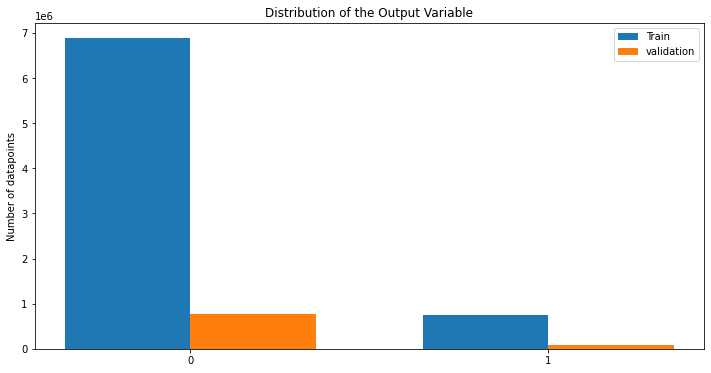

In [ ]:
#data split randomly

(X_train, y_train),(X_val, y_val) = random_split(test_size = 0.1)

In [ ]:
#feature scaling for logistic regression

from sklearn.preprocessing import StandardScaler

# fit scaler on training data
scaler = StandardScaler().fit(X_train)

# transforming the data
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)

In [ ]:
#saving standard scalar
from sklearn.externals import joblib 
joblib.dump(scaler, 'standrdscaler.pkl') 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['standrdscaler.pkl']

logloss on validation data : 0.2550918280106341


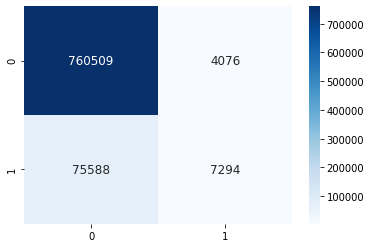

Accuracy : 0.9059975196674325
Precision : 0.6415127528583993
CPU times: user 6.98 s, sys: 1.11 s, total: 8.09 s
Wall time: 2min 19s


In [ ]:
%%time

log_reg = LogisticRegression(random_state=0, n_jobs = -1)
log_reg.fit(X_train_norm,y_train)

predict_y = log_reg.predict_proba(X_val_norm)
print("logloss on validation data :",log_loss(y_val, predict_y, labels=[0,1], eps=1e-15))
model_stats(np.argmax(predict_y,1),y_val)

In [ ]:
%%time

#get submission files on global thresholds
globl_threshold_products(model = log_reg, scaler = scaler, model_type = 'log_reg', val_file="Data_v2.h5")

#get products for order ID's and create a submission file based on local threshold
test_products = getscores_on_testdata(model = log_reg, scaler = scaler, model_type = 'log_reg', val_file="Data_v2.h5")
test_products.to_csv("submission_log_reg_v8.csv", index= False)

Generated submission_sample_v8_1_log_reg.csv successfully
Generated submission_sample_v8_2_log_reg.csv successfully
Generated submission_sample_v8_3_log_reg.csv successfully


100%|██████████| 75000/75000 [41:42<00:00, 29.97it/s]


CPU times: user 41min 58s, sys: 10.9 s, total: 42min 9s
Wall time: 42min 2s


### Decision Tree

In [ ]:
%%time
param_grid = {}
param_grid['max_depth'] = [5,10,15,20]
param_grid['min_samples_split'] = [2,3,4,5]

dt_clf = DecisionTreeClassifier()
r_search = RandomizedSearchCV(dt_clf, param_distributions=param_grid, cv = 5, verbose = True, n_jobs = -1)
r_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 48.7min finished


CPU times: user 18min 11s, sys: 1.44 s, total: 18min 13s
Wall time: 51min 3s


In [ ]:
r_search.best_params_

{'max_depth': 10, 'min_samples_split': 5}

logloss on validation data : 0.2509911734828939


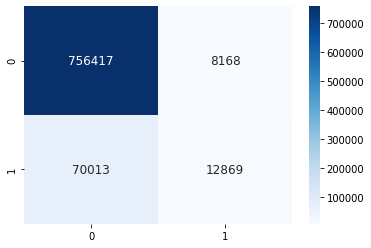

Accuracy : 0.9077474403133101
Precision : 0.6117317107952654


In [ ]:
predict_y = r_search.predict_proba(X_val)
print("logloss on validation data :",log_loss(y_val, predict_y, labels=[0,1], eps=1e-15))
model_stats(np.argmax(predict_y,1),y_val)

In [ ]:
%%time

#get submission files on global thresholds
globl_threshold_products(model = r_search, scaler = scaler, model_type = 'dt', val_file="Data_v2.h5")

#get products for order ID's and create a submission file based on local threshold
test_products = getscores_on_testdata(model = r_search, scaler = scaler, model_type = 'dt', val_file="Data_v2.h5")
test_products.to_csv("submission_dt_v8.csv", index= False)

### Random Forest

##### When to calibrate your model ?
ref: https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/

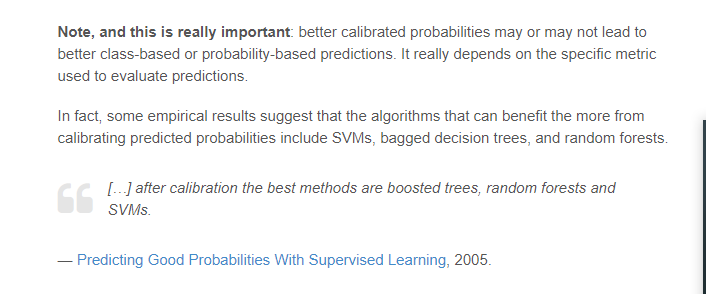

logloss on validation data : 0.25187675305313206


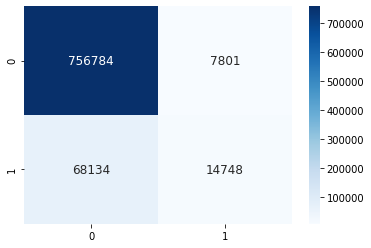

Accuracy : 0.9103976910015376
Precision : 0.6540423078628764
CPU times: user 2h 9min 57s, sys: 42.7 s, total: 2h 10min 40s
Wall time: 34min 57s


In [ ]:
%%time
#coderef: microsoft malware assignment

from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=25,random_state=42,n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_val)
print("logloss on validation data :",log_loss(y_val, predict_y, labels=[0,1], eps=1e-15))
model_stats(np.argmax(predict_y,1),y_val)

In [ ]:
%%time

#get submission files on global thresholds
globl_threshold_products(model = sig_clf, scaler = None, model_type = 'rf', val_file="Data_v2.h5")

#get products for order ID's and create a submission file based on local threshold
test_products = getscores_on_testdata(model = sig_clf, scaler = None, model_type = 'rf', val_file="Data_v2.h5")
test_products.to_csv("submission_rf_v8.csv", index= False)

Generated submission_sample_v8_1_rf.csv successfully
Generated submission_sample_v8_2_rf.csv successfully
Generated submission_sample_v8_3_rf.csv successfully


100%|██████████| 75000/75000 [41:58<00:00, 29.78it/s]


CPU times: user 54min 22s, sys: 10.1 s, total: 54min 33s
Wall time: 45min 36s


#### Multi Layer Perceptron Model

In [ ]:
## import tensorflow packages
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Input,Activation,Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

#SEED
SEED_VALUE = 0
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [ ]:
def mlp_model():
    """
    Create mlp model with 4 hidden layers .
    """
    inp = Input(shape =  (28,)) #no of features
    mlp = Dense(256, activation = "relu", kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_1')(inp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(128, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_2')(mlp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(64, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_3')(mlp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_4')(mlp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(1, activation = 'sigmoid', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_5')(mlp)

    model = Model(inputs = inp, outputs = mlp)
    
    opt = Adam(lr= 0.001)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [ ]:
import os

#save model checkpoint
filepath="saved_model/mlp/checkpoint.hdf5"

if not os.path.exists("saved_model/mlp/"):
    os.makedirs("saved_model/mlp/")    

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=2, verbose=1)

In [ ]:
tf.keras.backend.clear_session()

model = mlp_model()
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 256)               7424      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
fc_2 (Dense)                 (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
fc_3 (Dense)                 (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0     

In [ ]:
#train model
batch_size = 128
history = model.fit(X_train_norm,np.array(y_train).reshape(-1,1), epochs = 10, validation_data = (X_val_norm,np.array(y_val).reshape(-1,1)), callbacks=[checkpoint, earlystop])

Epoch 1/10
238350/238350 [==============================] - 515s 2ms/step - loss: 0.2631 - accuracy: 0.9042 - val_loss: 0.2548 - val_accuracy: 0.9044

Epoch 00001: val_accuracy improved from -inf to 0.90443, saving model to saved_model/mlp/checkpoint.hdf5
Epoch 2/10
238350/238350 [==============================] - 504s 2ms/step - loss: 0.2582 - accuracy: 0.9053 - val_loss: 0.2558 - val_accuracy: 0.9072

Epoch 00002: val_accuracy improved from 0.90443 to 0.90719, saving model to saved_model/mlp/checkpoint.hdf5
Epoch 3/10
238350/238350 [==============================] - 505s 2ms/step - loss: 0.2597 - accuracy: 0.9049 - val_loss: 0.2513 - val_accuracy: 0.9074

Epoch 00003: val_accuracy improved from 0.90719 to 0.90741, saving model to saved_model/mlp/checkpoint.hdf5
Epoch 4/10
238350/238350 [==============================] - 502s 2ms/step - loss: 0.2605 - accuracy: 0.9046 - val_loss: 0.2543 - val_accuracy: 0.9046

Epoch 00004: val_accuracy did not improve from 0.90741
Epoch 00004: early s

In [ ]:
#load the saved model and print accuracy

saved_model = tf.keras.models.load_model('saved_model/mlp/checkpoint.hdf5')
print("Training Accuracy :{:.2f} %".format(saved_model.evaluate(X_train_norm,np.array(y_train).reshape(-1,1), verbose = 0)[1]*100))
print("Validation Accuracy :{:.2f} %".format(saved_model.evaluate(X_val_norm,np.array(y_val).reshape(-1,1), verbose = 0)[1]*100))

Training Accuracy :90.75 %
Validation Accuracy :90.74 %


logloss on validation data : 0.2513314122715033


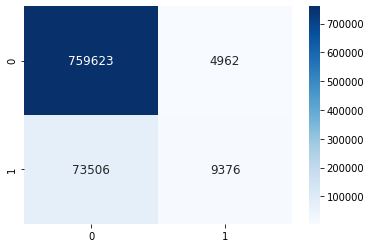

Accuracy : 0.9074087840588483
Precision : 0.6539266285395453


In [ ]:
#print model statistics

predict_y = saved_model.predict(X_val_norm)
print("logloss on validation data :",log_loss(y_val, predict_y.reshape(-1,).tolist(), labels=[0,1], eps=1e-15))
model_stats(predict_y,y_val)

In [ ]:
%%time

#get submission files on global thresholds
globl_threshold_products(model = saved_model, scaler = scaler, model_type = 'mlp', val_file="Data_v2.h5")

#get products for order ID's and create a submission file based on local threshold
test_products = getscores_on_testdata(model = saved_model, scaler = scaler, model_type = 'mlp', val_file="Data_v2.h5")
test_products.to_csv("submission_mlp_v8.csv", index= False)

Generated submission_sample_v8_1_mlp.csv successfully
Generated submission_sample_v8_2_mlp.csv successfully
Generated submission_sample_v8_3_mlp.csv successfully


100%|██████████| 75000/75000 [42:05<00:00, 29.70it/s]


CPU times: user 46min 50s, sys: 42.1 s, total: 47min 32s
Wall time: 45min 18s


##### Ensemble: XGBoost

In [ ]:
def train_xgb(X_train, X_test, y_train, y_test, plot_importance = True, save = True, file_name = None, params = None):
    
    """
    Returns trained XGB model and output probabilities of validation set
    
    Parameters
    ----------
    X_train              : X_train data is passed 
    X_test               : X_test data is passed
    y_train              : y_train data is passed
    y_test               : y_test data is passed
    plot_importance      : The default is True
                          Boolean variable , Set to True if feature Importance
                          needs to be plotted
    save                 : The default is True
                          Boolean variable , Set to True if trained model 
                          needs to be saved
    file_name            : The default is None
                          Filename to be used while saving model
    params               : The default is None
                          dict of parameter set used to train XGBoost model
    Returns
    -------
    xgb_model            :  Trained XGBoost Model
    predict_y            : output probabilities for validation data
    """

    #defining set of parameters, these are optimal parameters obatined after 
    # rigorous hyperparameter Tuning
    if params is None:
        params = {}
        params['objective'] = 'binary:logistic'
        params['eval_metric'] = ['logloss']
        params['eta'] = 0.02
        params['max_depth'] = 15
        params['nthread']=-1
        params['colsample_bytree'] = 0.4
        params['tree_method'] = 'gpu_hist'
        
    #Create DataMatrix for XGBoost
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_test = xgb.DMatrix(X_val, label=y_val)

    watchlist = [(d_train, 'train'), (d_test, 'valid')]
    
    #output Training Time
    start_time = datetime.now()
    print("Training Started :")
    xgb_model = xgb.train(params, d_train, 300, watchlist, early_stopping_rounds=20, verbose_eval=10)
    print("Training Completed ")
    end_time = datetime.now()
    difference = end_time - start_time
    time = divmod(difference.total_seconds() , 360)
    print("Total Time : {} minutes {} seconds".format(time[0], time[1]))
    
    #get probabilities for validation set
    predict_y = xgb_model.predict(d_test)
    print("The test log loss is:",log_loss(y_val, predict_y, labels=[0,1], eps=1e-15))
    
    #save trained model
    if save:
        #file_name = "xgb_v1.pkl"
        
        # save
        pickle.dump(bst, open(file_name, "wb"))
    
    #plot Feature Importance
    if plot_importance:
        print("Feature Importance")
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        xgb.plot_importance(booster = bst, ax = ax)

    return xgb_model, predict_y

Training Started :
[0]	train-logloss:0.67958	valid-logloss:0.679697
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.565498	valid-logloss:0.566859
[20]	train-logloss:0.485983	valid-logloss:0.488555
[30]	train-logloss:0.427436	valid-logloss:0.431356
[40]	train-logloss:0.381913	valid-logloss:0.387167
[50]	train-logloss:0.348537	valid-logloss:0.355125
[60]	train-logloss:0.322154	valid-logloss:0.330022
[70]	train-logloss:0.302482	valid-logloss:0.311674
[80]	train-logloss:0.28651	valid-logloss:0.297039
[90]	train-logloss:0.274486	valid-logloss:0.28634
[100]	train-logloss:0.263946	valid-logloss:0.277057
[110]	train-logloss:0.255393	valid-logloss:0.269897
[120]	train-logloss:0.248648	valid-logloss:0.264373
[130]	train-logloss:0.243342	valid-logloss:0.260319
[140]	train-logloss:0.238704	valid-logloss:0.257066
[150]	train-logloss:0.234887	valid-logloss:0.254566
[160]	train-

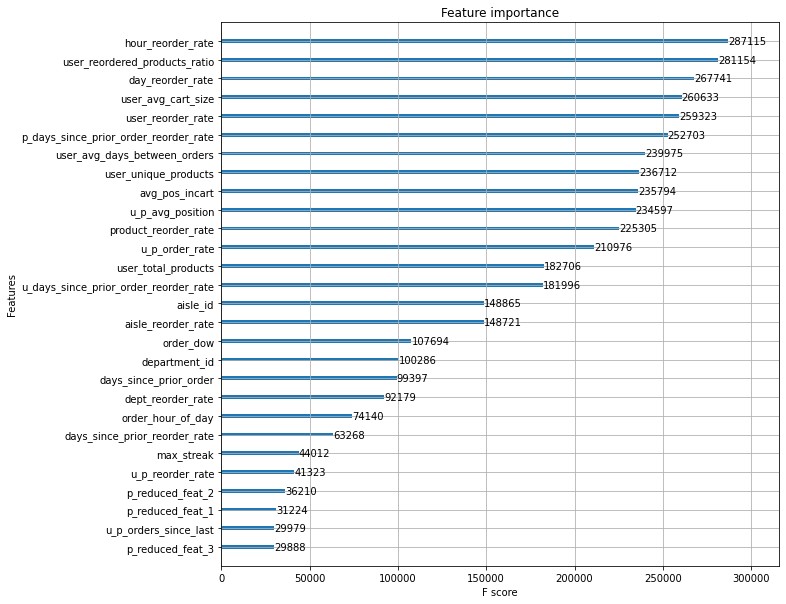

In [ ]:
xgb_model, predict_y = train_xgb(X_train, X_val, y_train, y_val, True, True, "xgb_v3.pkl", None)

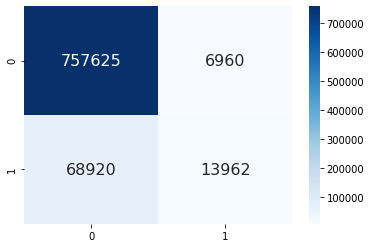

Accuracy : 0.9104625902837514
Precision : 0.6673358187553771


In [ ]:
# Plot confusion Matrix
predicted_y =np.array(predict_y>0.5,dtype=int)
cm = confusion_matrix(y_val, predicted_y)
sns.heatmap(cm, cmap='Blues', annot = True, fmt="g", annot_kws={"size": 16})
plt.show()
print("Accuracy :",accuracy_score(y_val, predicted_y))
print("Precision :",precision_score(y_val, predicted_y))

#### Create a Submission File

In [ ]:
#generate submission files based on global threshold
globl_threshold_products(model = pickle.load(open("xgb_v3.pkl", "rb")), model_type = 'xgb')

Generated submission_sample_v6.1_1_xgb.csv successfully
Generated submission_sample_v6.1_2_xgb.csv successfully
Generated submission_sample_v6.1_3_xgb.csv successfully


In [ ]:
#get products for order ID's and create a submission file based on local threshold
test_products = getscores_on_testdata(model = pickle.load(open("xgb_v3.pkl", "rb")), model_type = 'xgb')
test_products.to_csv("submission_xgb_v6.csv", index= False) # 0.39155 - 0.39303

100%|██████████| 75000/75000 [42:23<00:00, 29.48it/s]


### Ensemble: Catboost

In [ ]:
def train_catboost(X_train, X_test, y_train, y_test, plot_importance = True, save = True, file_name = None):
    
    """
    Returns trained catboost model and output probabilities of validation set
    
    Parameters
    ----------
    X_train              : X_train data is passed 
    X_test               : X_test data is passed
    y_train              : y_train data is passed
    y_test               : y_test data is passed
    plot_importance      : The default is True
                          Boolean variable , Set to True if feature Importance
                          needs to be plotted
    save                 : The default is True
                          Boolean variable , Set to True if trained model 
                          needs to be saved
    file_name            : The default is None
                          Filename to be used while saving model
    Returns
    -------
    xgb_model            :  Trained XGBoost Model
    predict_y            : output probabilities for validation data
    """


    start_time = datetime.now()
    print("Training Started :")

    #defining set of parameters, these are optimal parameters obatined after 
    # rigorous hyperparameter Tuning
    c_model = CatBoostClassifier(task_type = "GPU",verbose=True,depth = 13, iterations= 2000,learning_rate= 0.02,scale_pos_weight= 1.0)
    c_model.fit(X_train,y_train)
    print("Training Completed ")
    end_time = datetime.now()
    difference = end_time - start_time
    time = divmod(difference.total_seconds() , 3600)
    print("Total Time : {} hours {} seconds".format(time[0], time[1]))
    
    #get output probabilities
    predict_y = c_model.predict_proba(X_test)
    print("The Test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))
    
    #get probs for class 1
    predict_y = predict_y[:,-1]
    
    #save the model
    if save:
        # save
        pickle.dump(c_model, open(file_name, "wb"))
    
    #plot feature importance
    if plot_importance:
        #ref: https://stackoverflow.com/a/65842279/11533069
        f_imp=pd.DataFrame({'features':train_x.columns.to_numpy(),'feature_importance': c_model.get_feature_importance()})
        f_imp.sort_values(by = 'feature_importance', ascending = False, inplace = True)

        print("Feature Importance")
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        sns.barplot(x=f_imp['feature_importance'], y=f_imp['features'])
        plt.title('Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Features')

    return c_model, predict_y

Training Started :
0:	learn: 0.6682243	total: 213ms	remaining: 7m 4s
1:	learn: 0.6447123	total: 413ms	remaining: 6m 52s
2:	learn: 0.6226377	total: 616ms	remaining: 6m 50s
3:	learn: 0.6019817	total: 818ms	remaining: 6m 48s
4:	learn: 0.5821403	total: 1.02s	remaining: 6m 46s
5:	learn: 0.5640026	total: 1.23s	remaining: 6m 48s
6:	learn: 0.5468472	total: 1.44s	remaining: 6m 49s
7:	learn: 0.5307860	total: 1.64s	remaining: 6m 49s
8:	learn: 0.5154758	total: 1.84s	remaining: 6m 48s
9:	learn: 0.5011645	total: 2.05s	remaining: 6m 48s
10:	learn: 0.4874874	total: 2.26s	remaining: 6m 48s
11:	learn: 0.4746784	total: 2.47s	remaining: 6m 49s
12:	learn: 0.4626853	total: 2.68s	remaining: 6m 49s
13:	learn: 0.4509007	total: 2.88s	remaining: 6m 49s
14:	learn: 0.4401764	total: 3.09s	remaining: 6m 48s
15:	learn: 0.4299006	total: 3.29s	remaining: 6m 48s
16:	learn: 0.4204155	total: 3.49s	remaining: 6m 47s
17:	learn: 0.4112568	total: 3.7s	remaining: 6m 47s
18:	learn: 0.4027624	total: 3.9s	remaining: 6m 47s
19:	le

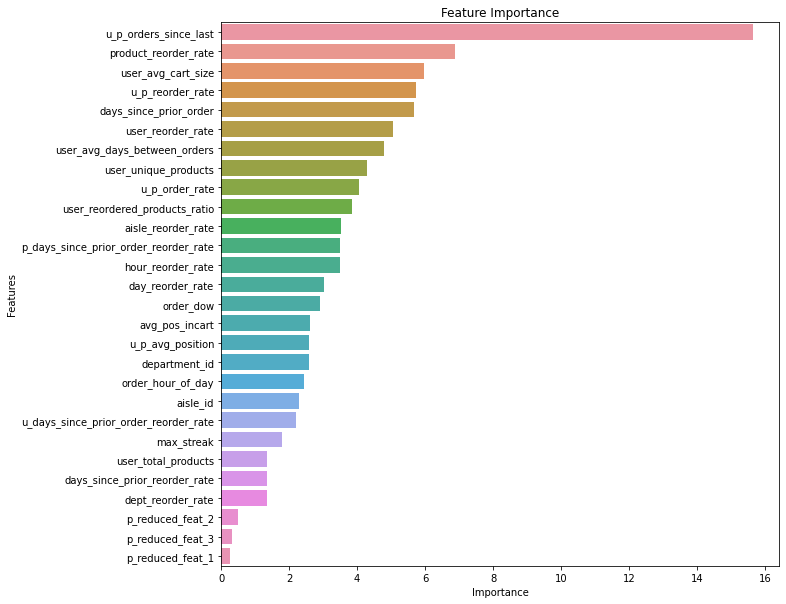

In [ ]:
c_model, predict_y = train_catboost(X_train, X_val, y_train, y_val, plot_importance = True, save = True, file_name = 'catboost_v3.pkl' )

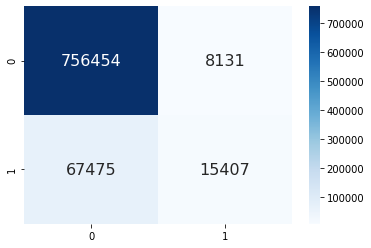

Accuracy : 0.9107859067078719
Precision : 0.6545585861160677


In [ ]:
#plot confusion matrix
predicted_y =np.array(predict_y>0.5,dtype=int)
cm = confusion_matrix(y_val, predicted_y)
sns.heatmap(cm, cmap='Blues', annot = True,  fmt="g", annot_kws={"size": 16})
plt.show()
print("Accuracy :",accuracy_score(y_val, predicted_y))
print("Precision :",precision_score(y_val, predicted_y))

#### Create a submission file

In [ ]:
#generate submission files based on global threshold
globl_threshold_products(model = pickle.load(open("catboost_v3.pkl", "rb")), model_type = 'catboost')

Generated submission_sample_v6.1_1_catboost.csv successfully
Generated submission_sample_v6.1_2_catboost.csv successfully
Generated submission_sample_v6.1_3_catboost.csv successfully


In [ ]:
#get products for order ID's and create a submission file based on local threshold
test_products = getscores_on_testdata(model = pickle.load(open("catboost_v3.pkl", "rb")), model_type = 'catboost')
test_products.to_csv("submission_catboost_v6.csv", index= False) #0.39498 0.39484

100%|██████████| 75000/75000 [42:43<00:00, 29.26it/s]


### Performance

We will compare all models for their mean f1-score on test set , on both global threshold and local threshold

In [ ]:
from prettytable import PrettyTable
# http://zetcode.com/python/prettytable/

x = PrettyTable()
x.field_names = ["Model", "logloss", "Threshold " , "Private Score" ,"Public Score"]
x.add_row(['Logistic Regression','0.2550','Global_Threshold : 0.18','0.35316','0.35485'])
x.add_row(['Logistic Regression','0.2550','Local_Threshold : faron_opt','0.37405','0.37687'])
x.add_row(['Decision Tree Classifier','0.2509','Global_Threshold : 0.20','0.28438', '0.28660'])
x.add_row(['Decision Tree Classifier','0.2509','Local_Threshold : faron_opt','0.29532', '0.29822'])
x.add_row(['Random Forest Classifier','0.2518','Global_Threshold : 0.18','0.35359','0.35456'])
x.add_row(['Random Forest Classifier','0.2518','Local_Threshold : faron_opt','0.37825','0.38067'])
x.add_row(['MLP model','0.2434','Global_Threshold : 0.18','0.35598','0.35630'])
x.add_row(['MLP model','0.2434','Local_Threshold : faron_opt','0.38327','0.38449'])
x.add_row(['XGB','0.2434','Global_Threshold : 0.18','0.36706','0.36815'])
x.add_row(['XGB','0.2434','Local_Threshold : faron_opt','0.39155','0.39303'])
x.add_row(['Catboost','0.2430','Global_Threshold : 0.18','0.36837','0.36850'])
x.add_row(['Catboost','0.2430','Local_Threshold : faron_opt','0.39498','0.39484'])

print(x)

+--------------------------+---------+-----------------------------+---------------+--------------+
|          Model           | logloss |          Threshold          | Private Score | Public Score |
+--------------------------+---------+-----------------------------+---------------+--------------+
|   Logistic Regression    |  0.2550 |   Global_Threshold : 0.18   |    0.35316    |   0.35485    |
|   Logistic Regression    |  0.2550 | Local_Threshold : faron_opt |    0.37405    |   0.37687    |
| Decision Tree Classifier |  0.2509 |   Global_Threshold : 0.20   |    0.28438    |   0.28660    |
| Decision Tree Classifier |  0.2509 | Local_Threshold : faron_opt |    0.29532    |   0.29822    |
| Random Forest Classifier |  0.2518 |   Global_Threshold : 0.18   |    0.35359    |   0.35456    |
| Random Forest Classifier |  0.2518 | Local_Threshold : faron_opt |    0.37825    |   0.38067    |
|        MLP model         |  0.2434 |   Global_Threshold : 0.18   |    0.35598    |   0.35630    |


For Local threshold :

Catboost > XGB > MLP > Random forest > Logistic Regression > Decision Tree

For Global threshold:

Catboost > XGB > MLP > Random forest > Logistic Regression > Decision Tree